Практический проект по сбору данных и работе с текстами 

Часть 1. Парсинг

Часть 2. NLP 


# Task: Nplus1 articles' difficulty predition

There are 2396 articles from news site with scientific-themed articles. 
The editors mark each article with 'difficulty'. Here's what they write about it:
Пытливый читатель обратил внимание, что у наших новостей есть параметр под названием сложность. Мы не претендуем на создание универсальной шкалы, в рамках которой можно бы было сравнивать материалы из разных областей знаний.

Наша сложность - это некоторая коллективная оценка редакции интеллектуальных усилий, которые понадобились редактору для написания заметки. Мы полагаем, что эти усилия пропорциональны усилиям, которые, следовательно, потребуются читателю для прочтения.

В общем, не воспринимайте сложность слишком серьезно.


I don't know how this difficulty metric gets calculated but there is a good chance that authors mark their articles themselves. Usually russian media do not employ too many people. I'll try to predict the difficulty based on a number of metrics:

Author's name
Time of the day when the article is published (in seconds)
Number of images in the article
Number of paragraph in the article
Number of hyperlinks in the article
Field of science

Name of the article
Text of the article


# Parsing

In [ ]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек 
import time          # Библиотека для времени
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm import tqdm_notebook
import datetime

In [ ]:
import socks
import socket
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [ ]:
def getPageLinks(month_number):
    page_link = 'https://nplus1.ru/news/2021/' + month_number
    response = requests.get(page_link)
    if not response.ok:
        return [] 

    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    news_links = soup.findAll(lambda tag: tag.name == 'a' and '/news/2021/' in tag.get('href'))
    news_links = ['https://nplus1.ru' + link.attrs['href'] for link in news_links]

    return news_links

In [ ]:
def getDifficulty(soup):
    try:
        difficulty = soup.find(lambda tag: tag.name == 'a' and 'difficult' in tag.get('href'))
        difficulty_coef=float(difficulty.get("href").split(sep='/')[-1])
    except:
        difficulty_coef=None
    return difficulty_coef

In [ ]:
def getRubric(soup):
    try:
        rubric = soup.find(lambda tag: tag.name == 'a' and tag.get('data-rubric'))
        rubric=(rubric.text.strip())
    except:
        rubric=None
    return rubric

In [ ]:
def getTime(soup):
    if soup.find(lambda tag: tag.name == 'time' and 'datePublished' in tag.get('itemprop')):
        time = soup.find(lambda tag: tag.name == 'time' and 'datePublished' in tag.get('itemprop'))
        seconds_count=(datetime.datetime.strptime(time.text.strip().split(sep='\n')[0], '%H:%M')-datetime.datetime.strptime('00:00', '%H:%M')).total_seconds()
    else:
        seconds_count=None
    return seconds_count

In [ ]:
def getName(soup):
    if  soup.find('h1'):
        name = soup.find('h1')
        name=name.text
    else:
        name=""
    return name


In [ ]:
def getText(soup):
    body = soup.find('div', attrs={'class':'js-mediator-article'})
    # раздел about (если он есть), должен идти первым, берем его без уточнения класса
    text_all = body.findAll('p',attrs={'class':''})
    if not text_all:
        return {'Author':"", 'Article':"", 'num_href': 0,'num_abzats':0,'num_img':0}
        
    Article=" ".join([x.text.strip() for x in text_all[:-1] if 'Поделиться' not in x.text])
    
    Author = body.findAll(lambda tag: tag.name == 'i' and not tag.get('class'))
    Author=Author[-1]
    Author=Author.text
    if 'редактора' in Author:
        Author = body.findAll(lambda tag: tag.name == 'i' and not tag.get('class'))
        Author=Author[-2]
        Author=Author.text
        Article=" ".join([x.text.strip() for x in text_all[:-2] if 'Поделиться' not in x.text])

    Author=" ".join(Author.split('\n'))
    Author=" ".join(Author.split('\r'))

    Article=" ".join(Article.split('\n'))
    Article=" ".join(Article.split('\r'))

    num_abzats=len(text_all)-1
    num_href = len(body.findAll('a'))

    img_title = body.findAll(lambda tag: tag.name == 'div' and tag.get('class')==['article-image'])
    img_in = body.findAll(lambda tag: tag.name == 'div' and tag.get('class')==['img'])
    num_img=(len(img_in)+len(img_title))
    
    return {'Author':Author, 'Article':Article, 'num_href': num_href,'num_abzats':num_abzats,'num_img':num_img}


In [ ]:
def getNplus1Data(page):
    # запрашиваем данные по ссылке
    response = requests.get(page, headers={'User-Agent': UserAgent().chrome})
    
    if not response.ok:
        # если сервер нам отказал, вернем статус ошибки 
        return response.status_code
    
    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    seconds = getTime(soup)
    rubric = getRubric(soup)
    difficulty = getDifficulty(soup)
    name = getName(soup)
    pagedata=page.split('/')
    date = "" if len(pagedata)<7 else '.'.join(pagedata[4:7])
#    print("seconds: {}\trubric: {}\tdifficulty: {}\tname: {}\tdate: {}".format(seconds, rubric, difficulty, name,date))
    text=getText(soup)

    # составляем словарь, в котором будут хранится все полученные и обработанные данные
    data_row = {"date_added":date, "rubric":rubric, 
                "difficulty":difficulty, "seconds":seconds, "name":name}
    data_row.update(text)

    return data_row

In [ ]:
final_df = pd.DataFrame(columns=['date_added', 'rubric', 'difficulty', 
                                  'Author','seconds','name',  'Article', 
                                 'num_href', 'num_abzats',"num_img"])

month_numbers=['01','02','03','04','05','06','07','08','09','10','11','12']

counter=0

for month in tqdm_notebook(month_numbers):
    newz_links = getPageLinks(month)
    for newwz_link in tqdm_notebook(newz_links):
        counter+=1
        if counter%100==1:
            final_df.to_csv('Nplus1_prelim_{}.csv'.format(int(counter/100)))
        try: 
            data_row = getNplus1Data(newwz_link)
            final_df = final_df.append(data_row, ignore_index=True)
            time.sleep(0.3102343)
        except:
            continue

final_df.to_csv('Nplus1_full.csv')

C:\Users\Pablo\AppData\Local\Temp/ipykernel_16284/2138579429.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for month in tqdm_notebook(month_numbers):


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Pablo\AppData\Local\Temp/ipykernel_16284/2138579429.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for newwz_link in tqdm_notebook(newz_links):


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
final_df.shape

(2396, 11)

In [ ]:
final_df['Author'].replace('', np.nan, inplace=True)
final_df['name'].replace('', np.nan, inplace=True)
final_df['Article'].replace('', np.nan, inplace=True)
final_df['rubric'].replace('', np.nan, inplace=True)

final_df['Author'].replace('nan', np.nan, inplace=True)
final_df['name'].replace('nan', np.nan, inplace=True)
final_df['Article'].replace('nan', np.nan, inplace=True)
final_df['rubric'].replace('nan', np.nan, inplace=True)

final_df.dropna(subset=['Author'], inplace=True)
final_df.dropna(subset=['name'], inplace=True)
final_df.dropna(subset=['Article'], inplace=True)
final_df.dropna(subset=['rubric'], inplace=True)

final_df.dropna()
final_df.shape

(2371, 11)

# EDA

In [ ]:
final_df.head()

,Unnamed: 0,date_added,rubric,difficulty,Author,seconds,name,Article,num_href,num_abzats,num_img
0,0,2021.01.30,Астрономия,1.9,Александр Войтюк,60720.0,Китайский космический гамма-монитор увидел сво...,Один из спутников китайского гамма-монитора вс...,3,5,3
1,1,2021.01.30,Оружие,3.1,Василий Сычёв,57360.0,Военные раскрыли характеристики модернизирован...,Министерство обороны России впервые обнародова...,1,4,1
2,2,2021.01.30,Оружие,3.1,Василий Сычёв,53400.0,Грузины занялись разработкой ударного беспилот...,Грузинское предприятие «Тбилавиамшени» занялос...,3,4,1
3,3,2021.01.30,Археология,1.9,Винера Андреева,49440.0,Амфоры с затонувшего корабля рассказали о торг...,Греческие археологи исследовали остатки античн...,7,11,5
4,4,2021.01.30,Оружие,3.1,Василий Сычёв,43980.0,Испытания гиперзвуковой ракеты «Циркон» заверш...,Государственные испытания перспективной гиперз...,3,4,1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Timestamp during day when Article published')

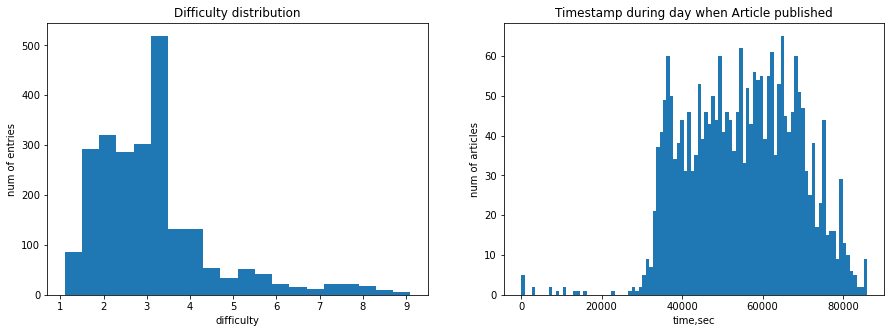

In [ ]:
plt.figure(figsize=(15,5))

#plot 1:
plt.subplot(1, 2, 1)
plt.hist(final_df['difficulty'], bins=20)
plt.xlabel('difficulty')
plt.ylabel('num of entries')
plt.title('Difficulty distribution')

#plot 2:
plt.subplot(1, 2, 2)
plt.hist(final_df['seconds'], bins=100)
plt.xlabel('time,sec')
plt.ylabel('num of articles')
plt.title('Timestamp during day when Article published')


The difficulty distribution looks more like Weibull distribution, than something bell-shaped like the Normal distribution.
There are 86400 seconds during day and 10:00 is around 36000th second. So the publishing work begins at 9 AM.

In [ ]:
final_df['rubric'].value_counts()

Археология           289
Оружие               247
Медицина             238
Зоология             218
Космонавтика         197
Астрономия           196
Физика               190
Авиация              121
Биология             118
Роботы и дроны        95
Транспорт             50
IT                    49
Палеонтология         49
Экология и климат     46
Психология            42
Антропология          41
Материалы             38
Химия                 31
Гаджеты               25
Геология              21
История               15
Мезонин               11
Ботаника              10
Связь                  6
3D-печать              6
Лингвистика            5
Инфопартнерство        4
Математика             4
Социология             4
Энергетика             2
Блоги                  1
Реклама                1
Экономика              1
Name: rubric, dtype: int64

ОДНА РАБОТА ПО БЛОГАМ, РЕКЛАМЕ и ЭКОНОМИКЕ ЗА ГОД!!!

In [ ]:
final_df['Author'].value_counts()

Александр Войтюк       323
Михаил Подрезов        271
Василиса Чернявцева    255
Сергей Коленов         236
Григорий Копиев        170
                      ... 
Илья Гриднев             1
Илья Беликов             1
Вера Мухина              1
Мухина Вера              1
Алекснадр Войтюк         1
Name: Author, Length: 74, dtype: int64

There are typos in names (Алекснадр Войтюк) and there are alot of authors 74!
Top author published an article almost once a day with ~35 'weekend' days! (An actual year has 3x times more weekend days)

In [ ]:
#final_df = pd.read_csv('Nplus1_full.csv')
#final_df.head()

# NLP 

## Prep

In [ ]:
names_articles = final_df['name']
data_articles = final_df['Article']
diffy= final_df['difficulty']

In [ ]:
names_articles=[str(x) for x in names_articles]
data_articles=[str(x) for x in data_articles]
lenin=[len(x) for x in data_articles]
lenin_names=[len(x) for x in names_articles]
##search for the smallest article
import numpy as np
print(min(lenin))
aa=np.array(lenin)
print(np.where(aa == aa.min()))
print(data_articles[764])

print(min(lenin_names))
aa1=np.array(lenin_names)
print(np.where(aa == aa.min()))
print(names_articles[763])

In [ ]:
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit

In [ ]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# примеры стоп-слов
stop_words[:3]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и', 'в', 'во']

In [ ]:
# знаки препинания
my_string_punctuation=string.punctuation+'«'+'»'

In [ ]:
my_string_punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'

In [ ]:
word_tokenizer = nltk.WordPunctTokenizer()

In [ ]:
dates = [str(x) for x in np.arange(1000, 2022)]
def process_data(data):
    texts = []
    targets = []
    
    # поочередно проходим по всем новостям в списке
    for item in data:
               
        text_lower = item.lower() # приводим все слова к нижнему регистру
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем екст на слова
        
        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in my_string_punctuation and word not in stop_words and word not in dates)]
        
        texts.append(tokens) # добавляем в предобработанный список
    
    return texts

In [ ]:
# запускаем нашу предобработку
texts = process_data(data_articles)
names = process_data(names_articles)

In [ ]:
# example
i = 1
print("Name: ", names[i])
print("Text: ", texts[i])
print("Difficulty: ", diffy[i])

Name:  ['военные', 'раскрыли', 'характеристики', 'модернизированного', 'комплекса', 'ярс']
Text:  ['министерство', 'обороны', 'россии', 'впервые', 'обнародовало', 'характеристики', 'модернизированного', 'стратегического', 'ракетного', 'комплекса', 'рс', '24', 'ярс', '».', 'сообщает', 'риа', 'новости', 'характеристики', 'комплекса', 'обнародованы', 'время', 'единого', 'дня', 'приемки', 'военной', 'техники', 'данным', 'министерства', 'обороны', 'россии', 'ярс', 'снаряжается', 'твердотопливными', 'баллистическими', 'ракетами', 'калибра', '1', '86', 'метра', 'длиной', '17', '8', 'метра', 'стартовая', 'масса', 'носителя', 'составляет', '46', 'тонн', 'массе', 'полезной', 'нагрузки', '1', '25', 'тонны', 'комплекс', 'поражать', 'цели', 'дальности', '10', 'тысяч', 'километров', 'настоящее', 'время', 'ракетных', 'войсках', 'стратегического', 'назначения', 'россии', 'опытно', 'боевом', 'дежурстве', 'комплексы', 'ярс', 'стоят', 'йошкар', 'оле', 'барнауле', 'перспективе', 'ракетные', 'дивизии', 'пл

In [ ]:
# загружаем библиотеку для лемматизации
import pymorphy2 # Морфологический анализатор

# инициализируем лемматизатор :)
morph = pymorphy2.MorphAnalyzer()

In [ ]:
# применяем лемматизацию ко всем текстам
for i in tqdm_notebook(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
    texts[i] = ' '.join(text_lemmatized)                # объединяем все слова в одну строку через пробел
    
for i in tqdm_notebook(range(len(names))):           # tqdm_notebook создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in names[i]] # применяем лемматизацию для каждого слова в тексте
    names[i] = ' '.join(text_lemmatized)                # объединяем все слова в одну строку через пробел

C:\Users\Pablo\AppData\Local\Temp/ipykernel_16284/1696498236.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)


  0%|          | 0/2371 [00:00<?, ?it/s]

C:\Users\Pablo\AppData\Local\Temp/ipykernel_16284/1696498236.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(names))):           # tqdm_notebook создает шкалу прогресса :)


  0%|          | 0/2371 [00:00<?, ?it/s]

In [ ]:
# example
i = 1
print("Name: ", names[i])
print("Text: ", texts[i])
print("Difficulty: ", diffy[i])

Name:  военный раскрыть характеристика модернизированный комплекс ярс
Text:  министерство оборона россия впервые обнародовать характеристика модернизированный стратегический ракетный комплекс рс 24 ярс ». сообщать риа новость характеристика комплекс обнародовать время единый день приёмка военный техника данные министерство оборона россия ярс снаряжаться твердотопливный баллистический ракета калибр 1 86 метр длина 17 8 метр стартовый масса носитель составлять 46 тонна масса полезный нагрузка 1 25 тонна комплекс поражать цель дальность 10 тысяча километр настоящий время ракетный войско стратегический назначение россия опытно боевой дежурство комплекс ярс стоять йошкара оля барнаул перспектива ракетный дивизия планироваться перевооружить модернизированный ракетный комплекс мобильный шахтный базирование стратегический ракетный комплекс ярс встать вооружение россия год мобильный установка оснастить трехступенчатый твердотопливный баллистический ракета стартовый масса 46 тонна носитель нести

In [ ]:
final_df.drop(columns=['name','Article'])

In [ ]:
final_df['name']=names
final_df['Article']=texts

In [ ]:
final_df.head()

,Unnamed: 0,date_added,rubric,difficulty,Author,seconds,name,Article,num_href,num_abzats,num_img
0,0,2021.01.30,Астрономия,1.9,Александр Войтюк,60720.0,китайский космический гамма монитор увидеть св...,спутник китайский гамма монитор небо gecam зар...,3,5,3
1,1,2021.01.30,Оружие,3.1,Василий Сычёв,57360.0,военный раскрыть характеристика модернизирован...,министерство оборона россия впервые обнародова...,1,4,1
2,2,2021.01.30,Оружие,3.1,Василий Сычёв,53400.0,грузин заняться разработка ударный беспилотник,грузинский предприятие тбилавиамшень заняться ...,3,4,1
3,3,2021.01.30,Археология,1.9,Винера Андреева,49440.0,амфора затонуть корабль рассказать торговый ма...,греческий археолог исследовать остаток античны...,7,11,5
4,4,2021.01.30,Оружие,3.1,Василий Сычёв,43980.0,испытание гиперзвуковой ракета циркон завершит...,государственный испытание перспективный гиперз...,3,4,1


In [ ]:
#final_df.to_csv('Nplus1_full_lemma_dropnan.csv')

In [ ]:
final_df = pd.read_csv('Nplus1_full_lemma_dropnan.csv')

# tf-idf and model training

In [ ]:
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(final_df, test_size=0.2, random_state=55)

txt_train=df_train['Article']
txt_test=df_test['Article']

diffy_train=df_train['difficulty']
diffy_test=df_test['difficulty']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Fit TF-IDF on train texts
vectorizer_text = TfidfVectorizer(max_features = 50) # топ 50 слов
vectorizer_text.fit(txt_train)
# Топ-10 слов
vectorizer_text.get_feature_names()[:20]

['автор',
 'вид',
 'время',
 'год',
 'группа',
 'два',
 'другой',
 'животное',
 'использовать',
 'испытание',
 'исследование',
 'исследователь',
 'компания',
 'который',
 'кроме',
 'масса',
 'метр',
 'мочь',
 'например',
 'находиться']

In [ ]:
# Обучаем TF-IDF на train, а затем применяем к train и test
train_X = vectorizer_text.fit_transform(txt_train)
test_X  = vectorizer_text.transform(txt_test)

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(train_X, diffy_train)
Y_pred_train = regressor.predict(train_X)
Y_pred_test = regressor.predict(test_X)


# Results

Text(0.5, 1.0, 'Predicted Difficulty distribution (Only 50 words)')

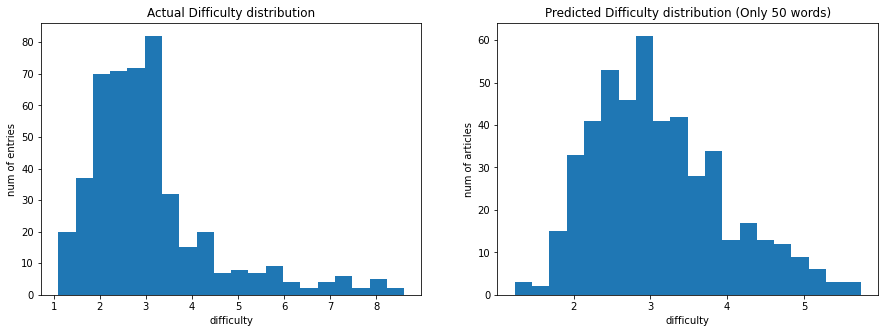

In [ ]:
plt.figure(figsize=(15,5))

#plot 1:
plt.subplot(1, 2, 1)
plt.hist(diffy_test, bins=20)
plt.xlabel('difficulty')
plt.ylabel('num of entries')
plt.title('Actual Difficulty distribution')

#plot 2:
plt.subplot(1, 2, 2)
plt.hist(Y_pred_test, bins=20)
plt.xlabel('difficulty')
plt.ylabel('num of articles')
plt.title('Predicted Difficulty distribution (Only 50 words)')


In [ ]:
from sklearn.metrics import mean_squared_error
print('Results based on 50 words')
print("Test MSE = %.4f" % mean_squared_error(diffy_test, Y_pred_test))
print("Train MSE = %.4f" % mean_squared_error(diffy_train, Y_pred_train))
chance=np.ndarray(len(diffy_test))
for i in range(len(diffy_test)):
    chance[i]=random.randrange(1, 99, 1)/10.0
print("Test based on guess MSE = %.4f" % mean_squared_error(diffy_test, chance))

Results based on 50 words
Test MSE = 1.1876
Train MSE = 1.1524
Test based on guess MSE = 12.5253


Prediction with only 50 words in the model provides us with a good MSE. 
The shape of the predicted distribution looks similar to the actual one.
The result is much better than any result with a random chance!
Still there's much to improve. It could be done simply by increasing the number of words.


Text(0.5, 1.0, 'Predicted Difficulty distribution (500 words)')

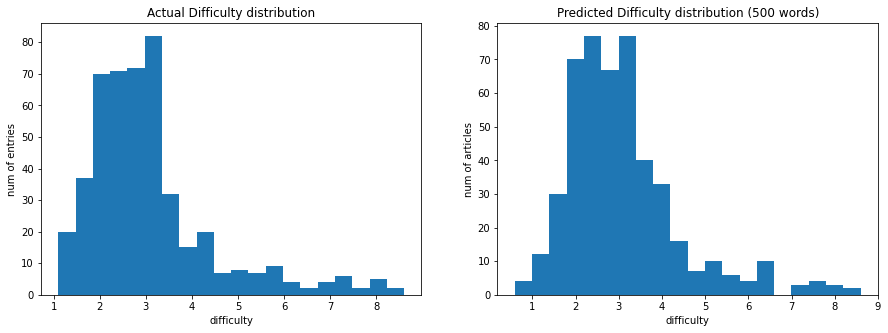

In [ ]:
plt.figure(figsize=(15,5))

#plot 1:
plt.subplot(1, 2, 1)
plt.hist(diffy_test, bins=20)
plt.xlabel('difficulty')
plt.ylabel('num of entries')
plt.title('Actual Difficulty distribution')

#plot 2:
plt.subplot(1, 2, 2)
plt.hist(Y_pred_test, bins=20)
plt.xlabel('difficulty')
plt.ylabel('num of articles')
plt.title('Predicted Difficulty distribution (500 words)')


In [ ]:
from sklearn.metrics import mean_squared_error
print('Results based on 500 words')
print("Test MSE = %.4f" % mean_squared_error(diffy_test, Y_pred_test))
print("Train MSE = %.4f" % mean_squared_error(diffy_train, Y_pred_train))
chance=np.ndarray(len(diffy_test))
for i in range(len(diffy_test)):
    chance[i]=random.randrange(1, 99, 1)/10.0
print("Test based on guess MSE = %.4f" % mean_squared_error(diffy_test, chance))


Results based on 500 words
Test MSE = 0.9306
Train MSE = 0.4597
Test based on guess MSE = 13.1805


Considering 500 top words in the analysis brings MSE below 1.0 and the distribution look much better in comparison to the actual distribution.

My initial goal was to combine data from TF-IDF with an additional article data. But i couldn't figure out how to create a combined dataset... And maybe apply some importance weights for individual columns.

It remains TBD.